### Build a heatmap over the allocation of the reciprocal best Hit BLAST results grouped by their organisms' genus

The reciprocal Best Hit BLAST results have to be converted from the html to a csv in a first step. 

The heatmap is created according to all accesion ids in the acc_id file. 

The names for the corresponding cluster have to be given as input argument (type: list of strings), in the same order as the accesion ids. If this list is not given, the accesion ids will be given as names on the heatmap.

##### TODOs 

- remove NaN row (?)
        - yes/no answer for abundance of proteins - > Do this in plot with maxval = 1
- how to create namelist - combining with WP? 


        - how many organisms in a genus - add in backets 
- define when extra sorting should be used
- clustering of the data

- get colormap with more than 20 colors 
        - where to add legend in heatmap plot? 
- define better posotion of the single subplots in complete heatmap 
- add extra sorting opinions (Cyanobacteria first etc)

In [1]:
import pandas as pd
import numpy as np

##for plotting:
import matplotlib as mlp
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

%matplotlib inline

In [2]:
'''
Function takes an input dataframe given through the reciprocal BLAST.
The genus for the corresponding protein(given through its WP) is filterd out and stored in a list.
The function returns a list of the genus of all organisms that realign best to the given protein number. 
input arguments: BLAST_output dataframe, preprocessed with the taxonomy script (type:dataframe, csv read in with pandas), WP_number to best realign to (type_string)
'''
def extract_genuslist(df, WP_num):
    genuslist= []
    gendict = {}
    for i in range(len(df)):
        if df.qseqid [i] == WP_num: # check if the hit belongs to the right protein
            if pd.isnull(df.genus[i]) == False: ## to sort out NaN values
                genuslist.append(df.genus[i]) # genuslist contains for ech hit for a specific protein the corespnding genus
                
                
   # add the number of corresponding organisms for each genus:              
                if df.genus[i] not in gendict.keys():
                    gendict[df.genus[i]] = [df.staxids[i]]
                else: 
                    if df.staxids[i] not in gendict[df.genus[i]]:
                        gendict[df.genus[i]].append(df.staxids[i])
    dictlist = list(gendict.keys())                    
    for j in range(len(dictlist)):
        gendict[dictlist[j]]= len(gendict[dictlist[j]])
    


    print('Entries in genuslist for', WP_num, ':', len(genuslist))
    return(genuslist, gendict)

In [ ]:
### probably not needed, has to be changes to search in complete datafile, not just in resultsfile.
def orgs_in_genus(df):
    gendict = {}
    for i in range (len(df)):
        if df.genus[i] not in gendict.keys():
            gendict[df.genus[i]] = [df.staxids[i]]
        else: 
            if df.staxids[i] not in gendict[df.genus[i]]:
                gendict[df.genus[i]].append(df.staxids[i])
    
    dictlist = list(gendict.keys())                    
    for j in range(len(dictlist)):
        gendict[dictlist[j]]= len(gendict[dictlist[j]])
        
    return(gendict)

In [3]:
'''
The function creates a table, where for each genus the corresponding phylum and superkingdom is stored 
in seperate columns. 
Input: BLAST_output dataframe, preprocessed with the taxonomy script (type:dataframe, csv read in with pandas)
'''

def get_taxonomy_table(df):
    taxdf= df[['genus','phylum','superkingdom' ]]
    taxdf = taxdf.drop_duplicates()

    return(taxdf)

In [4]:
'''
The function takes the genuslist and counts the occurence of each genus in the list.
Its outputs the number of occurences per genus in a dataframe.
Input arguments: list with all the geni of the organisms owning the protein(type: list) and the proteinname (type: string)
'''

def count_copies (genlist, protname):
    gendict = {x:genlist.count(x) for x in genlist}
    d =pd.DataFrame.from_dict(gendict,orient='index')
    d.columns = [protname]
    d.index.name = 'genus'
    d.reset_index(inplace=True)
    print('number of genera:', len(d))
    return(d)

In [ ]:
workingcsv=pd.read_csv('Completedata.csv')
extract_genuslist(workingcsv,'WP_011242471')

In [5]:
def get_dataframe (acc_ids, workingcsv, namelist = None, relatives = True):
    num_acc_ids = len(acc_ids)
    #gendict = orgs_in_genus(workingcsv)
    df_prot = get_taxonomy_table(workingcsv)
    
    
    for i in range(num_acc_ids):
        genus_data = extract_genuslist(workingcsv,acc_ids.iloc[i,0])
        genlist = genus_data[0]
        gendict = genus_data [1]
        df = count_copies(genlist,( namelist[i] if namelist else acc_ids.iloc[i,0]))
        #print(df)
        if relatives == True:
            for i in range(len(df)):
                df.iloc[i,1] = df.iloc[i,1]/gendict[df.genus[i]]
            
        #print(df)
        df_prot = pd.merge(df_prot, df, how='outer')
        
        
        
    df_prot = df_prot.drop_duplicates()
    df_prot = df_prot.fillna(0)   
    
    return(df_prot)

In [6]:
'''
Short function combining the functions above. 
Function takes the BLAST_data (Accession ID list (txt document) and BLAST result csv to read them in and creates a dataframe 
of the amount of occurence for all given protein clusters per genome. Only genomes that occur at least one at one protein cluster
are taken into consioderation)
'''
def first_frame(Acc_id_name, Resultcsv, namelist = None, relative = True):
    
    acc_ids = pd.read_csv(Acc_id_name, header=None)
    workingcsv = pd.read_csv(Resultcsv)
    
    frame= get_dataframe(acc_ids, workingcsv, namelist = namelist, relatives = relative)
    taxlist= ['phylum','superkingdom']
    protlist = namelist if namelist else acc_ids[0].tolist()
    collist = taxlist + protlist
    
    dat = frame[collist]
    dat.index= list(frame['genus'])
    
    print('Dataframe with shape', dat.shape, 'has been successfully created')
    return(dat)

In [ ]:
protnames=['BcsA1','XcsB2','BcsA2','XcsA','XcsB','XcsC','AcrA','AcrB','SFT','ABC1','ABC2','GTF1','GTF2','HlyD','peptidase','LptFG','LptB','LptA','LPS','LptC','LptD','FtsX','HlyD2','ABC3','HlyD3','PteB','RND1','RND2','TolC','MlaE','permease','S-layer','ABC4','ABC5','ABC6','TPR','RND3','export']

In [8]:
acc_ids = pd.read_csv('acc_ids.txt', header=None)

In [11]:
frame = first_frame('acc_ids.txt','Completedata.csv')

Entries in genuslist for WP_011378340 : 3327
number of genera: 365
Entries in genuslist for WP_011378341 : 231
number of genera: 40
Entries in genuslist for WP_011243364 : 404
number of genera: 124
Entries in genuslist for WP_011242471 : 285
number of genera: 64
Entries in genuslist for WP_039755718 : 1051
number of genera: 141
Entries in genuslist for WP_011378019 : 3836
number of genera: 440
Entries in genuslist for WP_011244046 : 3135
number of genera: 449
Entries in genuslist for WP_011378431 : 3222
number of genera: 463
Entries in genuslist for WP_011244513 : 3881
number of genera: 623
Entries in genuslist for WP_011378231 : 1856
number of genera: 410
Entries in genuslist for WP_011378232 : 2590
number of genera: 473
Entries in genuslist for WP_011378235 : 1273
number of genera: 468
Entries in genuslist for WP_011244503 : 1007
number of genera: 323
Entries in genuslist for WP_011244501 : 4164
number of genera: 449
Entries in genuslist for WP_011378236 : 3522
number of genera: 474


In [13]:
frame

,phylum,superkingdom,WP_011378340,WP_011378341,WP_011243364,WP_011242471,WP_039755718,WP_011378019,WP_011244046,WP_011378431,...,WP_011378177,WP_011243448,WP_011243394,WP_011243386,WP_011243384,WP_011243359,WP_011377610,WP_011377614,WP_011377621,WP_011377674
Escherichia,Proteobacteria,Bacteria,5.285714,1.0,0.0,0.000000,4.629630,0.000000,5.562500,1.937500,...,3.076923,3.000000,6.375000,0.0,1.500000,0.000000,0.000000,0.000000,1.000000,0.0
Variovorax,Proteobacteria,Bacteria,1.416667,0.0,0.0,0.000000,1.176471,1.000000,2.117647,1.545455,...,1.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,1.000000,1.142857,0.0
Streptomyces,Actinobacteria,Bacteria,1.156250,0.0,1.0,1.066667,0.000000,2.303797,0.000000,0.000000,...,0.000000,0.000000,1.692308,0.0,1.120482,2.721698,2.242857,0.000000,0.000000,0.0
Klebsiella,Proteobacteria,Bacteria,8.266667,0.0,0.0,0.000000,5.000000,0.000000,1.000000,7.709677,...,0.000000,1.272727,0.000000,0.0,4.962963,0.000000,2.687500,0.000000,4.347826,0.0
Vibrio,Proteobacteria,Bacteria,2.318182,0.0,0.0,0.000000,1.333333,1.400000,2.700000,3.157895,...,1.939394,1.490196,1.375000,0.0,2.250000,0.000000,1.333333,1.727273,2.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Staphylothermus,Crenarchaeota,Archaea,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
Bulleidia,Firmicutes,Bacteria,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
Mogibacterium,Firmicutes,Bacteria,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
Sneathia,Fusobacteria,Bacteria,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0


In [11]:
frame.to_csv('preprocessed_02.csv')

preprocessed.csv= without any counting of organisms per genus 

preprocessed_01.csv = count of organisms per genus in complete datafile

preprocessed_02.csv= count of organisms per genus per protein (built in function in extract genuslist)

### building dendrogram: 

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

In [3]:
frame02 = frame.iloc[:,2:]

In [13]:
### Get all the features columns except the class
features = list(frame.columns)[2:]

### Get the features data
data = frame[features]

In [16]:
clustering_kmeans = KMeans(n_clusters=27, precompute_distances="auto", n_jobs=-1)
data['clusters'] = clustering_kmeans.fit_predict(data)

C:\Users\Kathrin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
data

,WP_011378340,WP_011378341,WP_011243364,WP_011242471,WP_039755718,WP_011378019,WP_011244046,WP_011378431,WP_011244513,WP_011378231,...,WP_011243448,WP_011243394,WP_011243386,WP_011243384,WP_011243359,WP_011377610,WP_011377614,WP_011377621,WP_011377674,clusters
Escherichia,5.285714,1.0,0.0,0.000000,4.629630,0.000000,5.562500,1.937500,0.000000,0.000000,...,3.000000,6.375000,0.0,1.500000,0.000000,0.000000,0.000000,1.000000,0.0,20
Variovorax,1.416667,0.0,0.0,0.000000,1.176471,1.000000,2.117647,1.545455,1.125000,2.142857,...,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,1.000000,1.142857,0.0,9
Streptomyces,1.156250,0.0,1.0,1.066667,0.000000,2.303797,0.000000,0.000000,0.000000,1.149254,...,0.000000,1.692308,0.0,1.120482,2.721698,2.242857,0.000000,0.000000,0.0,22
Klebsiella,8.266667,0.0,0.0,0.000000,5.000000,0.000000,1.000000,7.709677,0.000000,1.000000,...,1.272727,0.000000,0.0,4.962963,0.000000,2.687500,0.000000,4.347826,0.0,20
Vibrio,2.318182,0.0,0.0,0.000000,1.333333,1.400000,2.700000,3.157895,2.240741,0.000000,...,1.490196,1.375000,0.0,2.250000,0.000000,1.333333,1.727273,2.000000,0.0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Staphylothermus,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,16
Bulleidia,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,16
Mogibacterium,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,16
Sneathia,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,16


In [19]:
sortdf = data.sort_values(by =['clusters'],ascending=[True])
sortdf.to_csv('k_means_try.csv')

# Further processing of the data:

In [2]:
frame = pd.read_csv('preprocessed_02.csv',index_col=0)

In [14]:
'''
function numbers the different phyla and superkingdoms and stores this in a dictionary. 
'''
def get_dict(frame, rank):
    if rank == 'phylum':
        r_list= list(frame.phylum.unique())
        
    if rank == 'superkingdom':
        r_list = list(frame.superkingdom.unique())
    
    r_dict = dict(zip(r_list, range(1, len(r_list)+1)))
    
    return(r_dict)

In [19]:
def get_cyanos_first(dictionary):
    num = dictionary['Cyanobacteria']
    res = list(dictionary.keys())[0]
    dictionary['Cyanobacteria'] = 1
    dictionary[res]= num
    return(dictionary)

In [21]:
'''
function changes the name of phylum or the superkingdom to a unique number. 
This is needed to create a colorsheme for the entries in the phylum or superkingdom. 
'''
def categories_taxonomy(frame, rank, r_dict):
    if rank == 'phylum':
        for i in range(len(r_dict)): 
            for j in range(len(frame)):
                if list(r_dict.keys())[i] == frame.iloc[j,0]:
                    frame.iloc[j,0]= list(r_dict.values())[i]

    if rank =='superkingdom':
        for i in range(len(r_dict)): 
            for j in range(len(frame)):
                if list(r_dict.keys())[i] == frame.iloc[j,1]:
                    frame.iloc[j,1]= list(r_dict.values())[i]
    
    return(frame)

In [22]:
'''
short function that crates a sub-dataframe from the overall-results-datadrame. 
Input: the results dataframe created with the function preparing_heatmap
        a list of strings containing the Protein Ids or names(if argument namelist given in preparing heatmap) 
            of the proteins needed in the sub-dataframe
'''
def create_subframes(df,columnnames):
    
    newframe= df[columnnames]
    
    return newframe

In [23]:
'''
The function sorts the dataframe after a defined order of proteinnames. 
Order can be defined on their own with the argument data_to_use.
datatype: list of two elements. 
        First element: List of the columnnames to sort in defined order e.g.['proteinname1','proteinname2']
        Second element: List of boolean vales if the columns should be sorted ascending. e.g.[True, False]
        
If the data_to_use argument is nor given, data will be sorted corresponding to all columns of the frames
with the phylum and the superkingdom ascending and the proteins descending. 
'''

def order_frame(frame, data_to_use =None):
    if data_to_use== None:
        listtoorder= list(frame.columns)
        listofbools = [True,True]+[False] * (len(frame.columns)-2)
    else:
        listtoorder= data_to_use[0]
        listofbools= data_to_use[1]
        
    sortdf2 = frame.sort_values(by =listtoorder,ascending=listofbools)
    return(sortdf2)

In [24]:
'''
Function checks for the abundance in the genera for specified proteins. Only if one of the proteins 
is present in the genus, this genus will stay in the heatmap, otherwise it will be deleted.
Input parameters: dataframe created with the function preparing heatmap 
                list of proteinnames to check after (Abundant prots)
'''
def has_protein(frame, Abundant_prots):
    df = create_subframes(frame, Abundant_prots)
    df = df.loc[(df!=0).any(axis=1)]
    result = frame.loc[list(df.index)]
    return(result)

In [25]:
def prepare_heatmapdata (df,given_prots=None, Cyanosfirst = False):
    if given_prots:
        df=has_protein(df,given_prots)
        
    s_dict = get_dict(df,'superkingdom')
    df = categories_taxonomy(df,'superkingdom',s_dict)
    df = order_frame(df,(['superkingdom'],[True]))
    
    p_dict = get_dict(df,'phylum')
    if Cyanosfirst == True:
        p_dict = get_cyanos_first(p_dict)
    df = categories_taxonomy(df,'phylum',p_dict)
    df = order_frame(df)
    
    return(df, s_dict,p_dict)

In [26]:
BcsAs= ['WP_011378340','WP_011243364','WP_011242471']

In [29]:
df_infos= prepare_heatmapdata(frame,given_prots=BcsAs, Cyanosfirst= True)
#df= df_infos[0]
#dict_sup=df_infos[1]
#dict_phy = df_infos[2]

In [40]:
df_infos[0].shape[]

(465, 40)

In [ ]:
import matplotlib._color_data as mcd
overlap = [name for name in mcd.CSS4_COLORS]



In [79]:
'''
function to create a heatmap, given the dataframe created with the function preparing_heatmap or create_subframes.

Addicitonal Input arguments: saving: string of the name the saved figure should have.(eg 'heatmap.pdf'). 
                                 If a name is given, the figure will be saved
                             log: is true, a logarithmic scale is chosen for the heatmap. 
                                 If False, the linear scale is chosen
'''
def create_heatmap(df_info, saving = None, log = True, maxval=None):
    
    fulldf= df_info[0]
    dict_sup=df_info[1]
    dict_phy = df_info[2]
    
    df= create_subframes(fulldf, list(frame.columns)[2:])
    df1=create_subframes(fulldf,['phylum']).astype(float)
    df2=create_subframes(fulldf,['superkingdom']).astype(float)
    df_sup = pd.DataFrame.from_dict(dict_sup,orient='index')
    df_phy = pd.DataFrame.from_dict(dict_phy,orient='index',columns=['num'])
    df_phy = df_phy.sort_values(by =['num'],ascending=[True])
    
    frameshape = df.shape
    if frameshape[0] < 100:
        f = plt.figure(figsize=(frameshape[1]/2+6,frameshape[0]/2))

        plots = gridspec.GridSpec(7, 8, wspace=0.05, hspace=0.1,
                              width_ratios=[1,0.5,1,0.5,frameshape[1]/2, 4,.5,5])
    
    else:
        f=  plt.figure(figsize=(frameshape[1]/2+6,100))

        plots = gridspec.GridSpec(7, 8, wspace=0.05, hspace=0.1,
                              width_ratios=[1,0.5,1,0.5,frameshape[1]/2, 4, .5,5])
    


    syn_heat = f.add_subplot(plots[0:6,4])
    
    # Remove the tick marks and place labels at top, bottom, and right  
    syn_heat.tick_params(axis="both", which="both", bottom= False, top=False,
                    left=False, right=False, labeltop=False, labelbottom="on", 
                    labelleft=False, labelright="on")

    syn_heat.set_xticks(np.arange(frameshape[1])+0.5, minor=False)
    syn_heat.set_yticks(np.arange(frameshape[0])+0.5, minor=False)
    
    # Add x-axis labels
    
    syn_heat.set_xticklabels(df.columns, fontsize=20, rotation=90)
        
    if frameshape[0] < 100:
        syn_heat.set_yticklabels(df.index, fontsize=20)
    else:
        syn_heat.set_yticklabels(df.index, fontsize=10)
       

    heat_syn = plt.pcolor(df,cmap= "Reds", vmax = maxval if maxval else None, norm=mlp.colors.LogNorm ()if log else None)
#------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------   
    Org_heat1 = f.add_subplot(plots[0:6,0], sharey= syn_heat)

    Org_heat1.tick_params(axis="both", which="both", bottom= False, top=False,
                    left=False, right=False, labeltop=False, labelbottom=False, 
                    labelleft=False, labelright=False)
    

    Org_heat1 = plt.pcolor(df1, cmap='gist_ncar')
   
    
 #--------------------------------------------------------------------------------------------   
    Org_heat2 = f.add_subplot(plots[0:6,2], sharey= syn_heat)

    Org_heat2.tick_params(axis="both", which="both", bottom= False, top=False,
                    left=False, right=False, labeltop=False, labelbottom=False, 
                    labelleft=False, labelright=False)
    

    Org_heat2 = plt.pcolor(df2,cmap='tab20')
    
#---------------------------------------------------------------------------------------------    
    

    bar_heat = f.add_subplot(plots[2,6])
    cbar = plt.colorbar(heat_syn, bar_heat )
    cbar.ax.tick_params(length=10, width=5)
    cbar.ax.tick_params(labelsize=20)
    #cbar.ax.set_yticklabels(fontsize=20)
    cbar.set_label('Protein abundance', fontsize=30)
#----------------------------------------------------------------------------------------------- 

    scale_sup = f.add_subplot(plots[1,7])
    scale_sup.set_anchor('W')
    cmap = mlp.cm.get_cmap('tab20', len(df_sup))
    colorlist= []
    for i in range(cmap.N):
        rgba = cmap(i)
        colorlist.append(mlp.colors.rgb2hex(rgba))
    
    plt.gca().set_axis_off()
    palette = dict(zip(list(df_sup.index), colorlist))
    handles = [mlp.patches.Patch(color=palette[x], label=x) for x in palette.keys()]
    plt.legend(handles=handles,title='Superkingdom')#, fontsize=18,title_fontsize=20)

    plt.gca().set_axis_off()
    
#----------------------------------------------------------------------------------------------- 

    scale_phy = f.add_subplot(plots[0,7])
    scale_phy.set_anchor('W')
    cmap = mlp.cm.get_cmap('gist_ncar', len(df_phy))
    colorlist= []
    for i in range(cmap.N):
        rgba = cmap(i)
        colorlist.append(mlp.colors.rgb2hex(rgba))
    
    plt.gca().set_axis_off()
    palette = dict(zip(list(df_phy.index), colorlist))
    handles = [mlp.patches.Patch(color=palette[x], label=x) for x in palette.keys()]
    plt.legend(handles=handles,title='Phylum', fontsize=15,title_fontsize=17)

    plt.gca().set_axis_off()

    
    if saving : 
        plt.savefig(saving)

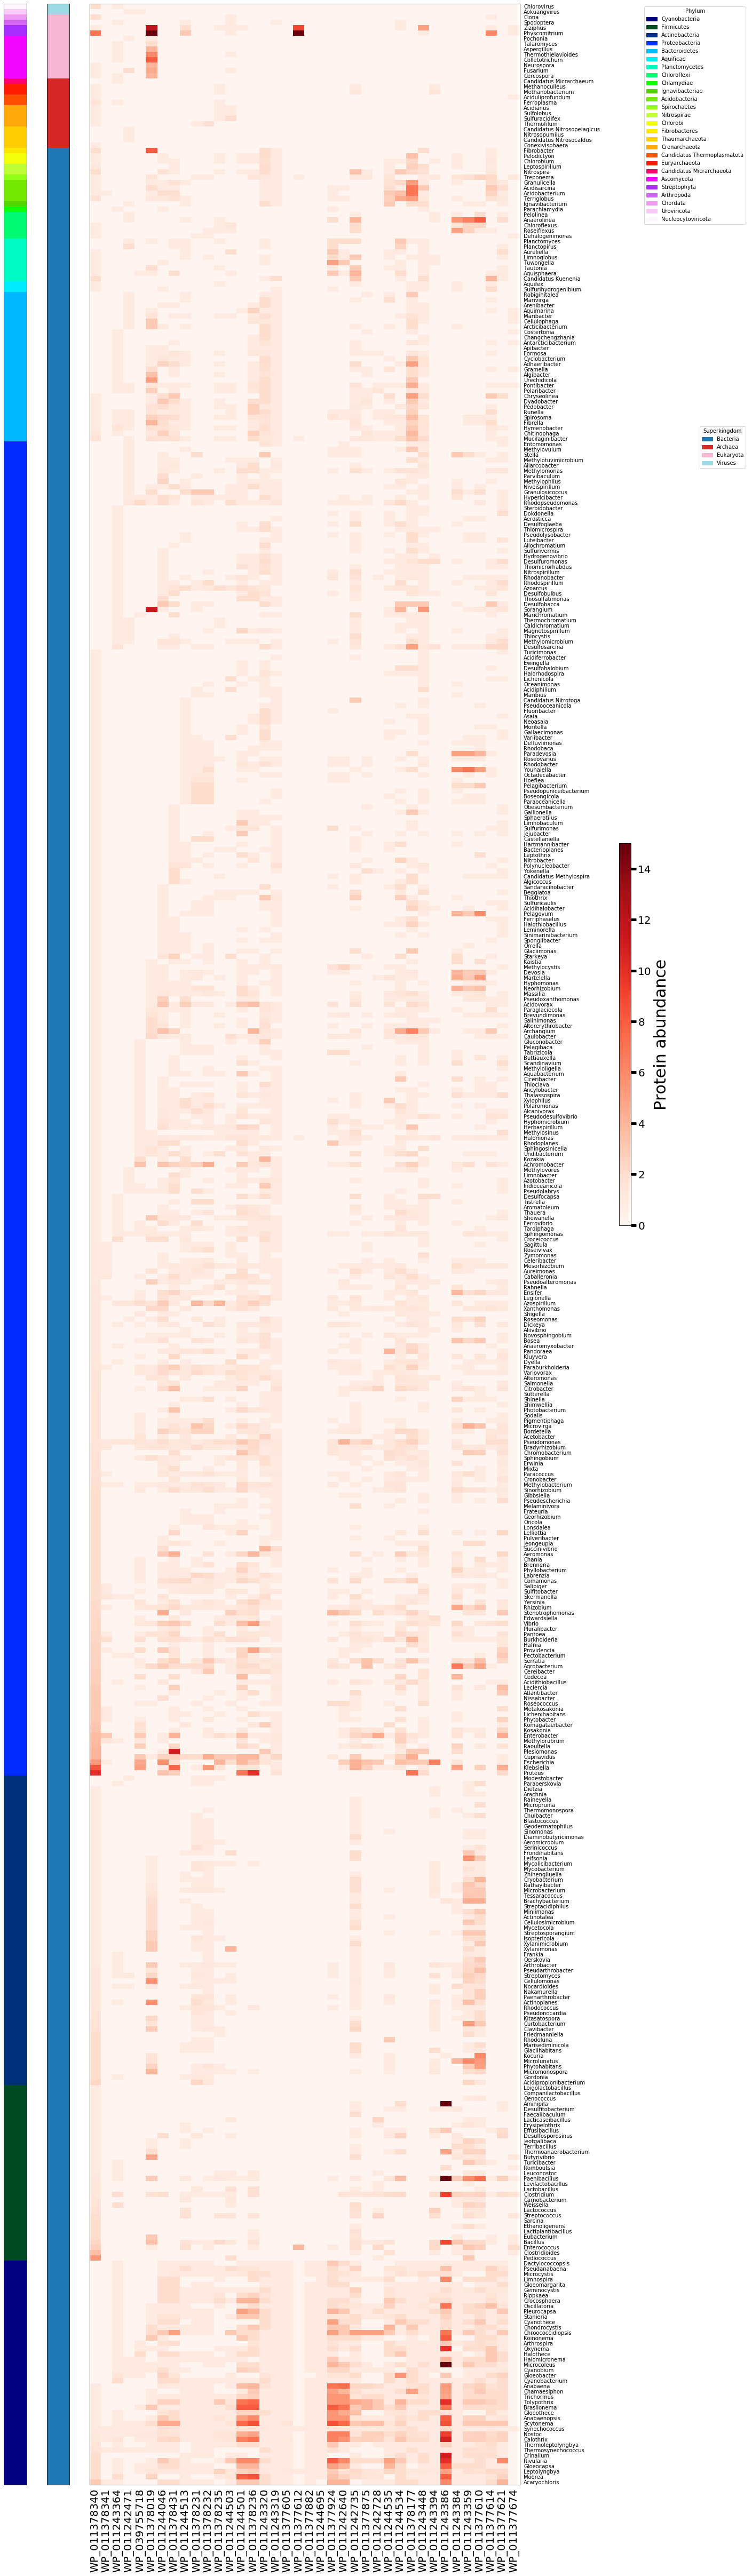

In [80]:
create_heatmap(df_infos, maxval=15, log =False)

In [ ]:
listofframes=[frame,SubA]

In [ ]:
'''
function to create a heatmap, given a lsi of dataframes created with the function preparing_heatmap or create_subframes.

Addicitonal Input arguments: saving: string of the name the saved figure should have.(eg 'heatmap.pdf'). 
                                 If a name is given, the figure will be saved
                             log: is true, a logarithmic scale is chosen for the heatmap. 
                                 If False, the linear scale is chosen
'''
def create_heatmap_from_list(dflist, saving = None, log = True):
    
    numframes= len(dflist)
    
    height = []
    width =[]
    maxval = []
    for i in range(numframes):
        height.append (listofframes[i].shape[0]/2)
        height.append (0.5)   
        width.append(listofframes[i].shape[1]/2)
        width.append(0.5)
        maxval.append(listofframes[i].max().max())
        
    
    width.append(3)    
    width.append(1) 
    sumheight= sum(height)
    sumwidth = sum(width) 
    
    max_value = max(maxval)
    
    print(height, width)
    
    f = plt.figure(figsize=(sumwidth+1,sumheight))

    plots = gridspec.GridSpec(1, numframes*2+2, wspace=0.05, hspace=0.1, width_ratios=width)

    for i in range(numframes):
        syn_heat = f.add_subplot(plots[0,i*2])
        frame = dflist[i]
        # Remove the tick marks and place labels at top, bottom, and right  
        if i == numframes-1:
            syn_heat.tick_params(axis="both", which="both", bottom= False, top=False,
                    left=False, right=False, labeltop=False, labelbottom="on", 
                    labelleft=False, labelright="on")
                 
            syn_heat.set_xticks(np.arange(frame.shape[1])+0.5, minor=False)
            syn_heat.set_yticks(np.arange(frame.shape[0])+0.5, minor=False)
                 
            syn_heat.set_xticklabels(frame.columns, fontsize=20, rotation=90)
            syn_heat.set_yticklabels(frame.index, fontsize=20)
   
                 
        else: 
            syn_heat.tick_params(axis="both", which="both", bottom= False, top=False,
                    left=False, right=False, labeltop=False, labelbottom="on", 
                    labelleft=False, labelright=False)     

            syn_heat.set_xticks(np.arange(frame.shape[1])+0.5, minor=False)
            #syn_heat.set_yticks(np.arange(frame.shape[0])+0.5, minor=False)
    

            syn_heat.set_xticklabels(frame.columns, fontsize=20, rotation=90)
            #syn_heat.set_yticklabels(df.index, fontsize=20)
   
        heat_syn = plt.pcolor(frame,cmap= "Reds",vmax= max_value ,norm=mlp.colors.LogNorm ()if log else None)


    bar_heat = f.add_subplot(plots[0,-1])
    cbar = plt.colorbar(heat_syn, bar_heat )
    cbar.ax.tick_params(length=10, width=5)
    cbar.ax.tick_params(labelsize=20)
    #cbar.ax.set_yticklabels(fontsize=20)
    cbar.set_label('Protein abundance', fontsize=30)
    
    
    
    if saving : 
        plt.savefig(saving)

In [ ]:
create_heatmap_from_list(listofframes, saving= 'multipleheatmaps.pdf')